In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

def gradient(y, x):
    return torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y),
                               create_graph=True, retain_graph=True)[0]
    
def to_tensor(x):
    return torch.tensor(x).float().to(device)

### Problem

$$\frac{\partial u}{\partial t} = \alpha\frac{\partial^2 u}{\partial x^2},\quad t\in [0, T],\quad x\in [0, L]$$

- Initial condition:

$$u(0, x) = \sin\left(\frac{n\pi x}{L}\right),\quad x\in [0, L]$$

- Boundary conditions:

$$u(t, 0) = u(t, L) = 0,\quad t\in [0, T]$$

- Exact solution:

$$u(t, x) = \sin\left(\frac{n\pi}{L}x\right)\exp\left(-\alpha\frac{n^2\pi^2}{L^2}t\right)$$

In [71]:
def show_result(t, x, U, title=""):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 3))
    for idx in (0, 50, 100, 150, 200, -1):
        ax1.plot(x, U[idx, :], label=f't={t[idx]:.2f}')
    ax1.set(xlabel='x', ylabel='u(t, x)', title=title)
    ax1.legend(loc="lower right", fontsize=8, frameon=False)
    ax1.grid(color='k', ls=':', lw=.5)

    img = ax2.imshow(U, cmap='rainbow', aspect='auto', interpolation='bilinear',
                    vmin=np.round(U.min()), vmax=np.round(U.max()),
                    origin='lower', extent=(x.min(), x.max(), t.min(), t.max()))
    ax2.set(xlabel='x', ylabel='t', title=title)
    fig.colorbar(img, ax=ax2)
    fig.tight_layout()
    plt.show()

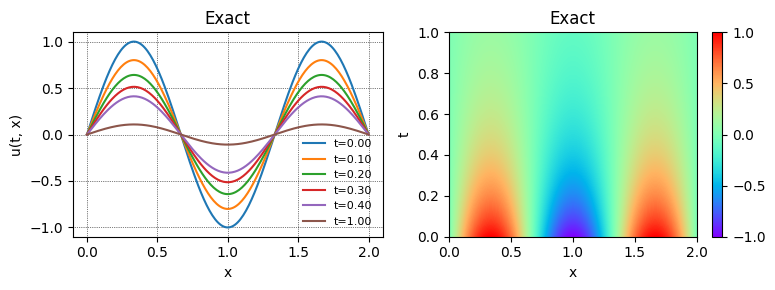

In [74]:
### Problem parameters
def u_exact(t, x, alpha, beta):
    return np.sin(beta * x) * np.exp(-alpha * beta**2 * t)

n = 3
t_min, t_max, t_size = 0, 1, 501
x_min, x_max, x_size = 0, 2, 201
alpha, beta = 0.1, n*np.pi/x_max

t = np.linspace(t_min, t_max, t_size)       # (t_size,)
x = np.linspace(x_min, x_max, x_size)       # (x_size,)
T, X = np.meshgrid(t, x, indexing="ij")     # (t_size, x_size)
U_exact = u_exact(T, X, alpha, beta)              # (t_size, x_size)

show_result(t, x, U_exact, title="Exact")

In [61]:
n_pde, n_ic, n_bc = 1000, 500, 500

## Domain: u_t - alpha * u_xx = 0
t_pde = torch.rand((n_pde, 1)) * t_max
x_pde = torch.rand((n_pde, 1)) * x_max

## Boundary condition: u(t, 0) = 0
t_bc1 = torch.rand((n_bc, 1)) * t_max
x_bc1 = torch.full_like(t_bc1, x_min)
u_bc1 = torch.full_like(t_bc1, 0)

## Boundary condition: u(t, x_max) = 0
t_bc2 = torch.rand((n_bc, 1)) * t_max
x_bc2 = torch.full_like(t_bc2, x_max)
u_bc2 = torch.full_like(t_bc2, 0)

## Initial condition: u(0, x) = sin(beta * x)
x_ic = torch.rand((n_ic, 1)) * x_max
t_ic = torch.full_like(x_ic, 0)
u_ic = torch.sin(beta * x_ic)

In [62]:
def residual_loss(model, t, x):
    t.requires_grad = True
    x.requires_grad = True

    u = model(t, x)
    u_t = gradient(u, t)
    u_xx = gradient(gradient(u, x), x)

    residual = u_t - alpha * u_xx
    return torch.mean(residual**2)

class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 50),  nn.Tanh(),
            nn.Linear(50, 50), nn.Tanh(),
            nn.Linear(50, 50), nn.Tanh(),
            nn.Linear(50, 1),)

    def forward(self, t, x):
        tx = torch.hstack([t, x])
        return self.model(tx)

### Training

In [64]:
## Training
n_epochs = 1000
learning_rate = 1e-3

model = PINN()
mse_loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.95)

for epoch in range(1, n_epochs + 1):
    model.train()
    loss_pde = residual_loss(model, t_pde, x_pde)
    loss_bc1 = mse_loss(model(t_bc1, x_bc1), u_bc1)
    loss_bc2 = mse_loss(model(t_bc2, x_bc2), u_bc2)
    loss_ic = mse_loss(model(t_ic, x_ic), u_ic)

    loss = loss_pde + loss_bc1 + loss_bc2 + loss_ic
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    if epoch % (n_epochs // 10) == 0:
        print(f"[{epoch:5d}/{n_epochs}] (lr: {scheduler.get_last_lr()[0]:.2e}) "
              f"loss: {loss.item():.2e} "
              f"(pde: {loss_pde.item():.2e} ic: {loss_ic.item():.2e} "
              f"bc1: {loss_bc1.item():.2e} bc2: {loss_bc2.item():.2e})")

[  100/1000] (lr: 9.50e-04) loss: 4.53e-01 (pde: 7.77e-03 ic: 4.25e-01 bc1: 1.12e-02 bc2: 9.07e-03)
[  200/1000] (lr: 9.02e-04) loss: 1.51e-01 (pde: 2.85e-02 ic: 1.04e-01 bc1: 3.54e-03 bc2: 1.50e-02)
[  300/1000] (lr: 8.57e-04) loss: 1.82e-02 (pde: 6.75e-03 ic: 8.14e-03 bc1: 9.34e-04 bc2: 2.37e-03)
[  400/1000] (lr: 8.15e-04) loss: 7.00e-03 (pde: 2.81e-03 ic: 2.17e-03 bc1: 3.35e-04 bc2: 1.69e-03)
[  500/1000] (lr: 7.74e-04) loss: 4.43e-03 (pde: 2.02e-03 ic: 1.09e-03 bc1: 1.75e-04 bc2: 1.14e-03)
[  600/1000] (lr: 7.35e-04) loss: 3.23e-03 (pde: 1.59e-03 ic: 6.44e-04 bc1: 1.16e-04 bc2: 8.81e-04)
[  700/1000] (lr: 6.98e-04) loss: 2.85e-03 (pde: 1.27e-03 ic: 4.80e-04 bc1: 8.46e-05 bc2: 1.01e-03)
[  800/1000] (lr: 6.63e-04) loss: 2.09e-03 (pde: 1.10e-03 ic: 3.46e-04 bc1: 6.83e-05 bc2: 5.70e-04)
[  900/1000] (lr: 6.30e-04) loss: 1.75e-03 (pde: 9.48e-04 ic: 2.72e-04 bc1: 5.55e-05 bc2: 4.75e-04)
[ 1000/1000] (lr: 5.99e-04) loss: 1.48e-03 (pde: 8.22e-04 ic: 2.18e-04 bc1: 4.56e-05 bc2: 3.98e-04)


### Evaluation

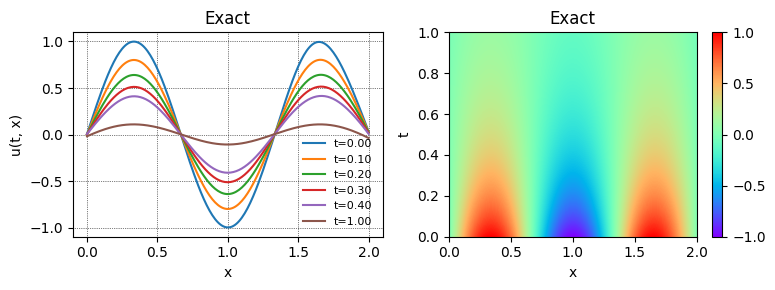

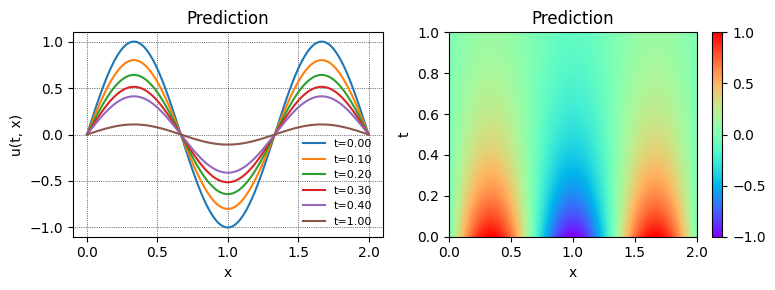

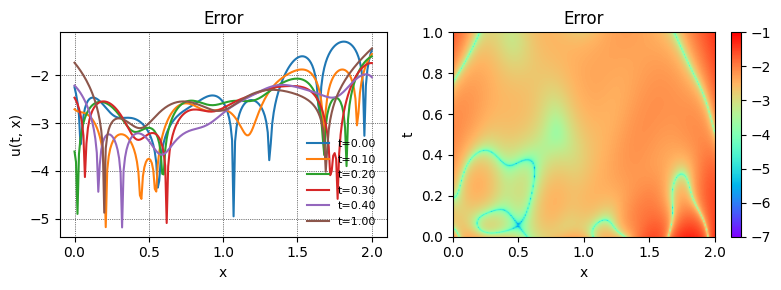

In [77]:
## Evaluation
with torch.no_grad():
    t_test = to_tensor(T.flatten()).view(-1, 1)
    x_test = to_tensor(X.flatten()).view(-1, 1)

    U_pred = model(t_test, x_test)
    U_pred = U_pred.reshape(t_size, x_size).numpy()

show_result(t, x, U_pred, title="Exact")
show_result(t, x, U_exact, title="Prediction")
show_result(t, x, np.log10(abs(U_exact - U_pred)), title="Error")